In [247]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge 
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

Loading data and minor cleaning/checking:

In [248]:
#load data
data=pd.read_csv('headlinesNLPdata.csv')
data.drop(columns='Unnamed: 0',inplace=True)
print(data.columns[0:50])

#Checking if we have categorical data
print(data.dtypes)
print(data.select_dtypes(include=['object','category']).head())

#Checking numeric feature ranges 
data.describe().T[['min','max']]
data.head()

Index(['return', 'direction', 'headline_length', 'word_count', 'day_0',
       'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'neg_sentiment',
       'neu_sentiment', 'pos_sentiment', 'compound_sentiment', 'finbert_neg',
       'finbert_neu', 'finbert_pos', '01', '02', '03', '04', '05', '06', '10',
       '11', '12', '13', '15', '19', '1h', '20', 'american', 'announces',
       'apple', 'bancorp', 'bank', 'beat', 'beats', 'big', 'business', 'buy',
       'capital', 'ceo', 'china', 'contract', 'covid', 'data', 'deal', 'debt'],
      dtype='object')
return             float64
direction            int64
headline_length      int64
word_count           int64
day_0                int64
                    ...   
technologies       float64
therapeutics       float64
trust              float64
vaccine            float64
year               float64
Length: 118, dtype: object
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]


,return,direction,headline_length,word_count,day_0,day_1,day_2,day_3,day_4,day_5,...,strong,study,systems,target,tech,technologies,therapeutics,trust,vaccine,year
0,-0.088750,0,78,11,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.243243,0,58,9,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.066434,1,65,8,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.155157,1,39,5,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.040924,1,78,9,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Data Preprocessing

In [249]:
#Separating features 
X=data.drop(columns=['return','direction'])
y=data['return']

#Features to scale (don't want to scale TF-IDF or dummy columns)
scale_features=['headline_length','word_count','neg_sentiment','neu_sentiment','pos_sentiment','compound_sentiment','finbert_neg','finbert_neu','finbert_pos']
no_scale_features=[c for c in X.columns if c not in scale_features]
preprocessor=ColumnTransformer([
    ("scale",StandardScaler(),scale_features),
    ("no_scale","passthrough",no_scale_features)
])
X_scaled=preprocessor.fit_transform(X)
X_scaled=pd.DataFrame(X_scaled,columns=preprocessor.get_feature_names_out(),index=X.index)

#Split into train and test sets 80/20
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.2,random_state=42)

We made sure to drop the return and direction values from our input data, as these features are relevant to the result which we seek to predict. Previously, we used 'direction' as one of the input features and obtained unrealistic results for directional accuracy. 

Ridge Regression (GridSearchCV)

In [250]:
ridge=Ridge()
ridge_params={'alpha':[0.01,0.1,1,10,50,100]}
grid_ridge=GridSearchCV(ridge,ridge_params,cv=5,scoring='neg_mean_squared_error') #negative MSE scoring, to minimize MSE by maximizing scoring metric
grid_ridge.fit(X_train,y_train)
best_ridge=grid_ridge.best_estimator_
y_pred_ridge=best_ridge.predict(X_test)
y_true_bin=(np.sign(y_test)>0).astype(int)
y_pred_bin=(np.sign(y_pred_ridge)>0).astype(int)

ridge_mse=mean_squared_error(y_test,y_pred_ridge) #MSE
ridge_mae=mean_absolute_error(y_test,y_pred_ridge) #MAE
ridge_r2=r2_score(y_test,y_pred_ridge) #r2 score
ridge_dir_acc=np.mean(np.sign(y_pred_ridge)==np.sign(y_test)) #direction of return accuracy
ridge_prec=precision_score(y_true_bin,y_pred_bin)
ridge_rec=recall_score(y_true_bin,y_pred_bin)
ridge_f1=f1_score(y_true_bin,y_pred_bin)

print("Ridge Regression:")
print("Best alpha: ",grid_ridge.best_params_)
print(f"MSE: {ridge_mse:.4f}, MAE: {ridge_mae:.4f}, R²: {ridge_r2:.4f}, Direction Accuracy: {ridge_dir_acc:.4f}\n, Direction Precision: {ridge_prec:.4f}\n, Direction Recall: {ridge_rec:.4f}\n, Direction F1: {ridge_f1:.4f}\n")


Ridge Regression:
Best alpha:  {'alpha': 100}
MSE: 0.0078, MAE: 0.0386, R²: 0.0071, Direction Accuracy: 0.5347
, Direction Precision: 0.5485
, Direction Recall: 0.6429
, Direction F1: 0.5920



Ridge regression is a linear model with one hyperparameter (alpha). Thus we use GridSearchCV here which is efficient since we can exhaustively test a small range of values.

Random Forest (RandomizedSearchCV)

In [251]:
rf=RandomForestRegressor(random_state=42)
rf_param_dist={
    'n_estimators':[100,200,500,1000],
    'max_depth':[5,10,20,None],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4]
}
rf_random=RandomizedSearchCV(rf,param_distributions=rf_param_dist,n_iter=10,cv=3,scoring='neg_mean_squared_error',n_jobs=-1,random_state=42)
rf_random.fit(X_train,y_train)
best_rf=rf_random.best_estimator_
y_pred_rf=best_rf.predict(X_test)
y_true_bin=(np.sign(y_test)>0).astype(int)
y_pred_bin=(np.sign(y_pred_rf)>0).astype(int)

rf_mse=mean_squared_error(y_test,y_pred_rf)
rf_mae=mean_absolute_error(y_test,y_pred_rf)
rf_r2=r2_score(y_test,y_pred_rf)
rf_dir_acc=np.mean(np.sign(y_pred_rf)==np.sign(y_test))
rf_prec=precision_score(y_true_bin,y_pred_bin)
rf_rec=recall_score(y_true_bin,y_pred_bin)
rf_f1=f1_score(y_true_bin,y_pred_bin)

print("Random Forest:")
print("Best params:",rf_random.best_params_)
print(f"MSE: {rf_mse:.4f}, MAE: {rf_mae:.4f}, R²: {rf_r2:.4f}, Direction Accuracy: {rf_dir_acc:.4f}\n, Direction Precision: {rf_prec:.4f}\n, Direction Recall: {rf_rec:.4f}\n, Direction F1: {rf_f1:.4f}\n")

Random Forest:
Best params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 10}
MSE: 0.0079, MAE: 0.0391, R²: 0.0041, Direction Accuracy: 0.5342
, Direction Precision: 0.5391
, Direction Recall: 0.6485
, Direction F1: 0.5887



Random Forest is an ensemble of decision trees capturing non-linear interactions and feature importance. Since it has many hyperparameters, making a full grid search is too expensive so we opt for RandomizedSearchCV which is more practical to find strong configurations quickly.  

XGBoost (RandomizedSearchCV)

In [252]:
xgb=XGBRegressor(random_state=42,objective='reg:squarederror')
xgb_param_dist={
    'n_estimators':[100,200,500],
    'max_depth':[3,5,7],
    'learning_rate':[0.01,0.05,0.1],
    'subsample':[0.6,0.8,1]
}
xgb_random=RandomizedSearchCV(xgb,param_distributions=xgb_param_dist,n_iter=10,cv=3,scoring='neg_mean_squared_error',n_jobs=-1,random_state=42)
xgb_random.fit(X_train,y_train)
best_xgb=xgb_random.best_estimator_
y_pred_xgb=best_xgb.predict(X_test)
y_true_bin=(np.sign(y_test)>0).astype(int)
y_pred_bin=(np.sign(y_pred_xgb)>0).astype(int)

xgb_mse=mean_squared_error(y_test,y_pred_xgb)
xgb_mae=mean_absolute_error(y_test,y_pred_xgb)
xgb_r2=r2_score(y_test,y_pred_xgb)
xgb_dir_acc=np.mean(np.sign(y_pred_xgb)==np.sign(y_test))
xgb_prec=precision_score(y_true_bin,y_pred_bin)
xgb_rec=recall_score(y_true_bin,y_pred_bin)
xgb_f1=f1_score(y_true_bin,y_pred_bin)


print("XGBoost:")
print("Best params:",xgb_random.best_params_)
print(f"MSE: {xgb_mse:.4f}, MAE: {xgb_mae:.4f}, R²: {xgb_r2:.4f}, Direction Accuracy: {xgb_dir_acc:.4f}\n, Direction Precision: {xgb_prec:.4f}\n, Direction Recall: {xgb_rec:.4f}\n, Direction F1: {xgb_f1:.4f}\n")

XGBoost:
Best params: {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01}
MSE: 0.0079, MAE: 0.0383, R²: -0.0013, Direction Accuracy: 0.5073
, Direction Precision: 0.5055
, Direction Recall: 0.9417
, Direction F1: 0.6579



XGBoost is a gradient boosting model that works very well on tabular data. Like Random Forest it has many hyperparameters and is better suited to RandomizedSearchCV. 

Comparison

In [253]:
#Feature importance 
ridge_importance=pd.Series(best_ridge.coef_,index=X_train.columns).sort_values(key=abs,ascending=False)
rf_importance=pd.Series(best_rf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
xgb_importance=pd.Series(best_xgb.feature_importances_,index=X_train.columns).sort_values(ascending=False)

print("Top Ridge features:\n", ridge_importance.head(5))
print("\nTop RF features:\n", rf_importance.head(5))
print("\nTop XGB features:\n", xgb_importance.head(5))

Top Ridge features:
 no_scale__fda         0.018408
no_scale__gainers     0.016467
no_scale__day_1       0.013040
no_scale__stage       0.012798
no_scale__offering   -0.009935
dtype: float64

Top RF features:
 scale__finbert_pos        0.187737
scale__finbert_neu        0.127298
scale__finbert_neg        0.116013
scale__headline_length    0.107660
no_scale__gainers         0.071706
dtype: float64

Top XGB features:
 no_scale__fda             0.204336
no_scale__day_1           0.109211
scale__finbert_neu        0.093561
scale__finbert_neg        0.083464
scale__headline_length    0.042354
dtype: float32


In [254]:
results = {
    "Model": ["Ridge", "Random Forest", "XGBoost"],
    "MSE":   [ridge_mse, rf_mse, xgb_mse],
    "MAE":   [ridge_mae, rf_mae, xgb_mae],
    "R²":    [ridge_r2, rf_r2, xgb_r2],
    "Direction Accuracy": [ridge_dir_acc, rf_dir_acc, xgb_dir_acc],
    "Direction Precision": [ridge_prec, rf_prec, xgb_prec],
    "Direction Recall": [ridge_rec, rf_rec, xgb_rec],
    "Direction F1": [ridge_f1, rf_f1, xgb_f1]
}

df = pd.DataFrame(results)
styled_table = (
    df.style
      .set_caption("Model Performance Comparison")
      .set_properties(**{
          "font-size": "12pt",
          "text-align": "center"
      })
      .hide(axis="index")
      .format({
          "MSE": "{:.4f}",
          "MAE": "{:.4f}",
          "R²": "{:.4f}",
          "Direction Acc.": "{:.4f}",
          "Precision": "{:.2f}",
          "Recall": "{:.2f}",
          "F1": "{:.2f}"
      })
)

styled_table

Model,MSE,MAE,R²,Direction Accuracy,Direction Precision,Direction Recall,Direction F1
Ridge,0.0078,0.0386,0.0071,0.534719,0.548516,0.642857,0.591952
Random Forest,0.0079,0.0391,0.0041,0.534247,0.539062,0.648496,0.588737
XGBoost,0.0079,0.0383,-0.0013,0.507322,0.505550,0.941729,0.657912


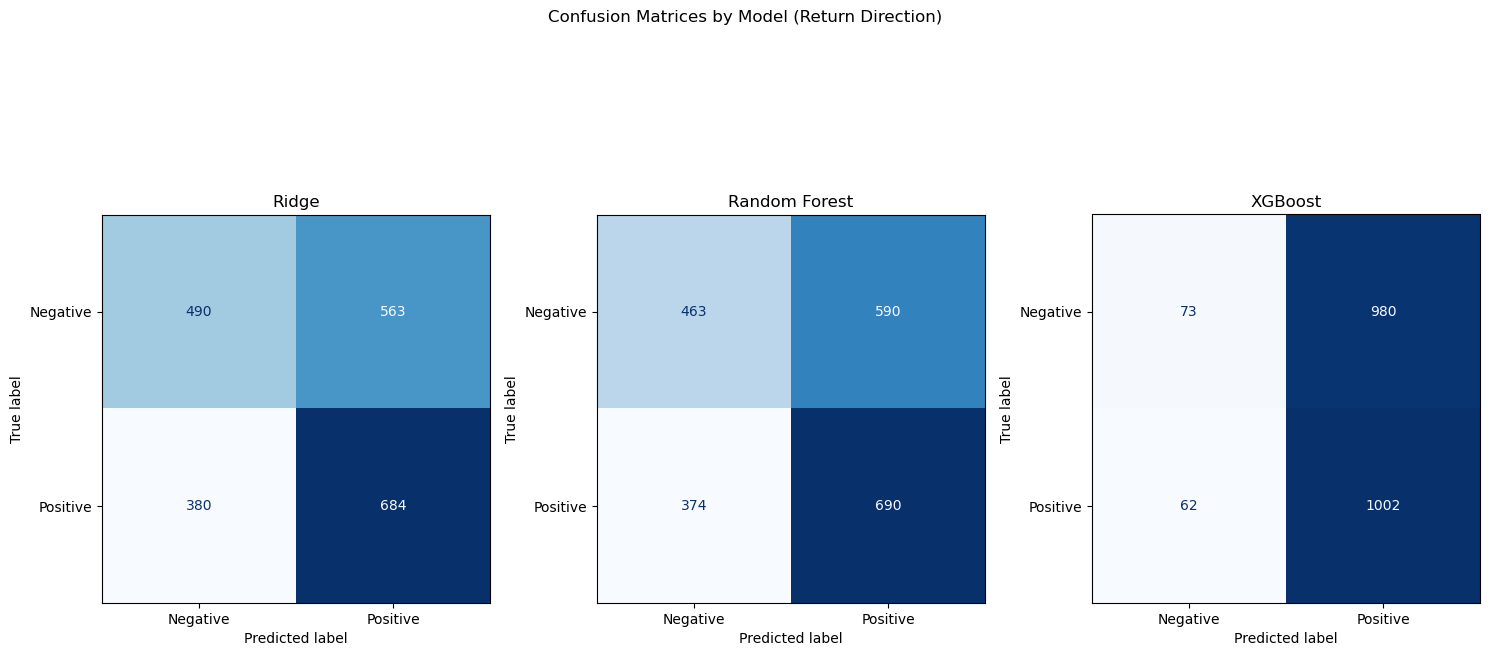

In [255]:
#Confusion matrices
ridge_bin=(np.sign(y_pred_ridge)>0).astype(int)
rf_bin=(np.sign(y_pred_rf)>0).astype(int)
xgb_bin=(np.sign(y_pred_xgb)>0).astype(int)

ridge_cm=confusion_matrix(y_true_bin,ridge_bin)
rf_cm=confusion_matrix(y_true_bin,rf_bin)
xgb_cm=confusion_matrix(y_true_bin,xgb_bin)

fig,axes=plt.subplots(1,3,figsize=(15,8))

for ax,cm,title in zip(axes,[ridge_cm, rf_cm, xgb_cm],["Ridge", "Random Forest", "XGBoost"]):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(ax=ax, colorbar=False, cmap="Blues")
    ax.set_title(title)

plt.suptitle("Confusion Matrices by Model (Return Direction)")
plt.tight_layout()
plt.show()

Clearly, our models performances are mediocre... Dissapointing, but this may be a result of the fact that we have made this a regression problem where the target is the raw return. The returns may be too close to random and are centered around 0 with most being tiny, especially since these are returns from the next trading day. Let's try again but with y = direction, such that this becomes a classification problem: 

In [256]:
#Separating features 
X=data.drop(columns=['return','direction'])
y=data['direction']

#Features to scale (don't want to scale TF-IDF or dummy columns)
scale_features=['headline_length','word_count','neg_sentiment','neu_sentiment','pos_sentiment','compound_sentiment','finbert_neg','finbert_neu','finbert_pos']
no_scale_features=[c for c in X.columns if c not in scale_features]
preprocessor=ColumnTransformer([
    ("scale",StandardScaler(),scale_features),
    ("no_scale","passthrough",no_scale_features)
])
X_scaled=preprocessor.fit_transform(X)
X_scaled=pd.DataFrame(X_scaled,columns=preprocessor.get_feature_names_out(),index=X.index)

#Split into train and test sets 80/20
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.2,random_state=42)

In [257]:
ridge=RidgeClassifier()
ridge_params={'alpha':[0.01,0.1,1,10,50,100]}
grid_ridge=GridSearchCV(ridge,ridge_params,cv=5,scoring='accuracy')
grid_ridge.fit(X_train,y_train)
best_ridge=grid_ridge.best_estimator_
y_pred_ridge=best_ridge.predict(X_test)

ridge_acc=accuracy_score(y_test,y_pred_ridge) 
ridge_prec=precision_score(y_test,y_pred_ridge)
ridge_rec=recall_score(y_test,y_pred_ridge)
ridge_f1=f1_score(y_test,y_pred_ridge)

print("Ridge Classifier:")
print("Best alpha: ",grid_ridge.best_params_)
print(f"Direction Accuracy: {ridge_acc:.4f}\n, Direction Precision: {ridge_prec:.4f}\n, Direction Recall: {ridge_rec:.4f}\n, Direction F1: {ridge_f1:.4f}\n")

Ridge Classifier:
Best alpha:  {'alpha': 100}
Direction Accuracy: 0.5465
, Direction Precision: 0.5890
, Direction Recall: 0.3233
, Direction F1: 0.4175



In [258]:
rf=RandomForestClassifier(random_state=42)
rf_param_dist={
    'n_estimators':[100,200,500,1000],
    'max_depth':[5,10,20,None],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4]
}
rf_random=RandomizedSearchCV(rf,param_distributions=rf_param_dist,n_iter=10,cv=3,scoring='accuracy',n_jobs=-1,random_state=42)
rf_random.fit(X_train,y_train)
best_rf=rf_random.best_estimator_
y_pred_rf=best_rf.predict(X_test)

rf_acc=accuracy_score(y_test,y_pred_rf)
rf_prec=precision_score(y_test,y_pred_rf)
rf_rec=recall_score(y_test,y_pred_rf)
rf_f1=f1_score(y_test,y_pred_rf)

print("Random Forest:")
print("Best params:",rf_random.best_params_)
print(f"Direction Accuracy: {rf_acc:.4f}\n, Direction Precision: {rf_prec:.4f}\n, Direction Recall: {rf_rec:.4f}\n, Direction F1: {rf_f1:.4f}\n")

Random Forest:
Best params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10}
Direction Accuracy: 0.5352
, Direction Precision: 0.5844
, Direction Recall: 0.2603
, Direction F1: 0.3602



In [259]:
xgb=XGBClassifier(random_state=42,use_label_encoder=False,eval_metric='logloss')
xgb_param_dist={
    'n_estimators':[100,200,500],
    'max_depth':[3,5,7],
    'learning_rate':[0.01,0.05,0.1],
    'subsample':[0.6,0.8,1]
}
xgb_random=RandomizedSearchCV(xgb,param_distributions=xgb_param_dist,n_iter=10,cv=3,scoring='accuracy',n_jobs=-1,random_state=42)
xgb_random.fit(X_train,y_train)
best_xgb=xgb_random.best_estimator_
y_pred_xgb=best_xgb.predict(X_test)

xgb_acc=accuracy_score(y_test,y_pred_xgb)
xgb_prec=precision_score(y_test,y_pred_xgb)
xgb_rec=recall_score(y_test,y_pred_xgb)
xgb_f1=f1_score(y_test,y_pred_xgb)


print("XGBoost:")
print("Best params:",xgb_random.best_params_)
print(f"Direction Accuracy: {xgb_acc:.4f}\n, Direction Precision: {xgb_prec:.4f}\n, Direction Recall: {xgb_rec:.4f}\n, Direction F1: {xgb_f1:.4f}\n")

XGBoost:
Best params: {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01}
Direction Accuracy: 0.5300
, Direction Precision: 0.6169
, Direction Recall: 0.1711
, Direction F1: 0.2678



In [260]:
#Feature importance 
ridge_importance=pd.Series(best_ridge.coef_[0],index=X_train.columns).sort_values(key=abs,ascending=False)
rf_importance=pd.Series(best_rf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
xgb_importance=pd.Series(best_xgb.feature_importances_,index=X_train.columns).sort_values(ascending=False)

print("Top Ridge features:\n", ridge_importance.head(5))
print("\nTop RF features:\n", rf_importance.head(5))
print("\nTop XGB features:\n", xgb_importance.head(5))

Top Ridge features:
 scale__headline_length   -0.008866
no_scale__leads          -0.008866
no_scale__partners       -0.008866
no_scale__pandemic       -0.008866
no_scale__outlook        -0.008866
dtype: float64

Top RF features:
 scale__finbert_pos        0.074081
scale__finbert_neu        0.073018
scale__finbert_neg        0.065622
scale__headline_length    0.062832
no_scale__day_1           0.042255
dtype: float64

Top XGB features:
 no_scale__holdings    0.017901
no_scale__day_1       0.015983
no_scale__results     0.015539
no_scale__day_2       0.014814
no_scale__1h          0.014036
dtype: float32


In [261]:
results = {
    "Model": ["Ridge", "Random Forest", "XGBoost"],
    "Direction Accuracy": [ridge_acc, rf_acc, xgb_acc],
    "Direction Precision": [ridge_prec, rf_prec, xgb_prec],
    "Direction Recall": [ridge_rec, rf_rec, xgb_rec],
    "Direction F1": [ridge_f1, rf_f1, xgb_f1]
}

df = pd.DataFrame(results)
styled_table = (
    df.style
      .set_caption("Model Performance Comparison")
      .set_properties(**{
          "font-size": "12pt",
          "text-align": "center"
      })
      .hide(axis="index")
      .format({
          "Direction Acc.": "{:.4f}",
          "Precision": "{:.2f}",
          "Recall": "{:.2f}",
          "F1": "{:.2f}"
      })
)

styled_table

Model,Direction Accuracy,Direction Precision,Direction Recall,Direction F1
Ridge,0.546528,0.589041,0.323308,0.417476
Random Forest,0.535191,0.584388,0.260338,0.360208
XGBoost,0.529995,0.616949,0.171053,0.267844


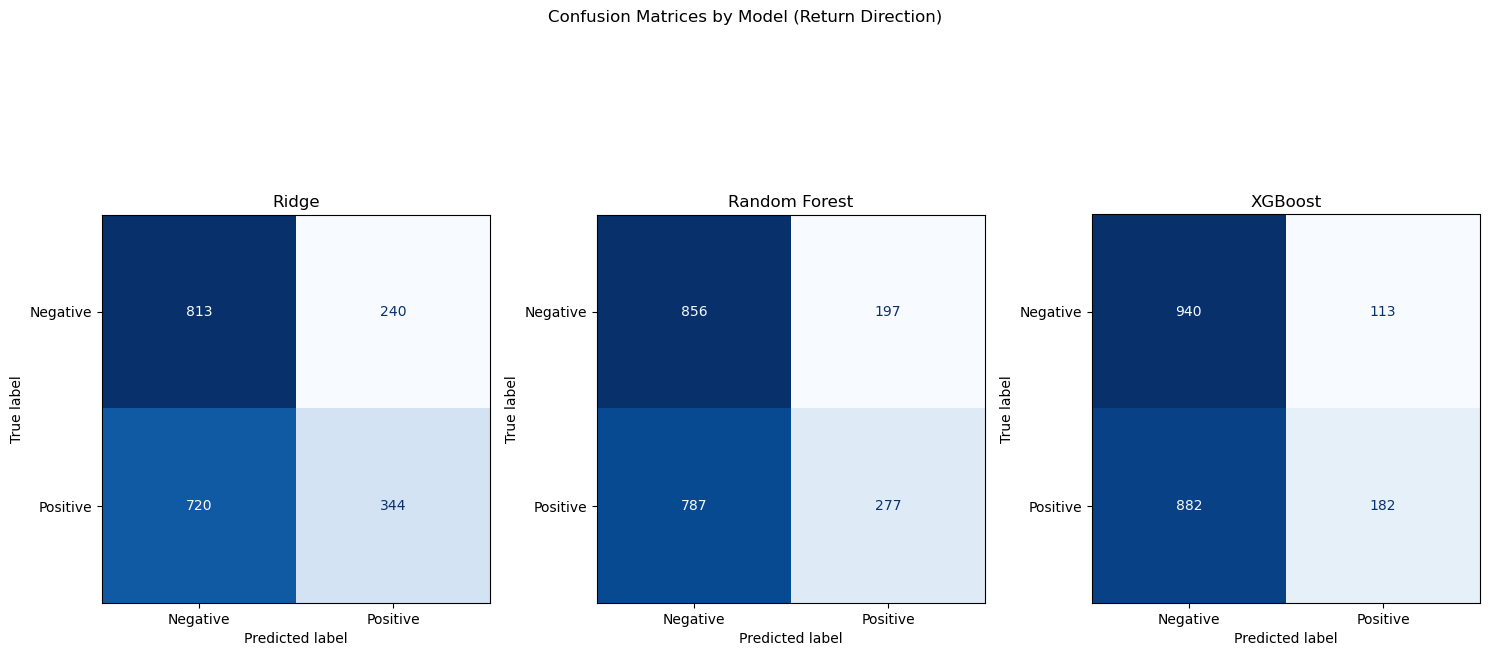

In [262]:
#Confusion matrices
ridge_cm=confusion_matrix(y_test,y_pred_ridge)
rf_cm=confusion_matrix(y_test,y_pred_rf)
xgb_cm=confusion_matrix(y_test,y_pred_xgb)

fig,axes=plt.subplots(1,3,figsize=(15,8))

for ax,cm,title in zip(axes,[ridge_cm, rf_cm, xgb_cm],["Ridge", "Random Forest", "XGBoost"]):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(ax=ax, colorbar=False, cmap="Blues")
    ax.set_title(title)

plt.suptitle("Confusion Matrices by Model (Return Direction)")
plt.tight_layout()
plt.show()

It seems like the performance is a bit better, but still not outstanding, probably because the raw direction is too noisy. In other words, tiny changes in returns might be indistinguishable from random market noise, so our model is being asked to predict randomness. Perhaps we should group small changes into a "neutral" bucket, to focus on large moves only, and potentially get a cleaner signal. 

In [263]:
X=data.drop(columns=['return','direction'])

#threshold
thresh=0.001

def categorize_return(r): 
    if r<=-thresh: 
        return -1
    elif r>=thresh: 
        return 1
    else: 
        return 0
    
y_class=data['return'].apply(categorize_return)
print(y_class.value_counts())

scale_features=['headline_length','word_count','neg_sentiment','neu_sentiment','pos_sentiment','compound_sentiment','finbert_neg','finbert_neu','finbert_pos']
no_scale_features=[c for c in X.columns if c not in scale_features]
preprocessor=ColumnTransformer([
    ("scale",StandardScaler(),scale_features),
    ("no_scale","passthrough",no_scale_features)
])
X_scaled=preprocessor.fit_transform(X)
X_scaled=pd.DataFrame(X_scaled,columns=preprocessor.get_feature_names_out(),index=X.index)
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y_class,test_size=0.2,random_state=42,stratify=y_class)


return
-1    4989
 1    4870
 0     723
Name: count, dtype: int64


In [264]:
ridge=RidgeClassifier()
ridge_params={'alpha':[0.01,0.1,1,10,50,100]}
grid_ridge=GridSearchCV(ridge,ridge_params,cv=5,scoring='accuracy')
grid_ridge.fit(X_train,y_train)
best_ridge=grid_ridge.best_estimator_
y_pred_ridge=best_ridge.predict(X_test)

ridge_acc=accuracy_score(y_test,y_pred_ridge) 
ridge_prec=precision_score(y_test,y_pred_ridge,average="weighted")
ridge_rec=recall_score(y_test,y_pred_ridge,average="weighted")
ridge_f1=f1_score(y_test,y_pred_ridge,average="weighted")

print("Ridge Classifier:")
print("Best alpha: ",grid_ridge.best_params_)
print(f"Direction Accuracy: {ridge_acc:.4f}\n, Direction Precision: {ridge_prec:.4f}\n, Direction Recall: {ridge_rec:.4f}\n, Direction F1: {ridge_f1:.4f}\n")

Ridge Classifier:
Best alpha:  {'alpha': 1}
Direction Accuracy: 0.5068
, Direction Precision: 0.5063
, Direction Recall: 0.5068
, Direction F1: 0.4976



In [265]:
rf=RandomForestClassifier(random_state=42)
rf_param_dist={
    'n_estimators':[100,200,500,1000],
    'max_depth':[5,10,20,None],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4]
}
rf_random=RandomizedSearchCV(rf,param_distributions=rf_param_dist,n_iter=10,cv=3,scoring='accuracy',n_jobs=-1,random_state=42)
rf_random.fit(X_train,y_train)
best_rf=rf_random.best_estimator_
y_pred_rf=best_rf.predict(X_test)

rf_acc=accuracy_score(y_test,y_pred_rf)
rf_prec=precision_score(y_test,y_pred_rf,average="weighted")
rf_rec=recall_score(y_test,y_pred_rf,average="weighted")
rf_f1=f1_score(y_test,y_pred_rf,average="weighted")

print("Random Forest:")
print("Best params:",rf_random.best_params_)
print(f"Direction Accuracy: {rf_acc:.4f}\n, Direction Precision: {rf_prec:.4f}\n, Direction Recall: {rf_rec:.4f}\n, Direction F1: {rf_f1:.4f}\n")

Random Forest:
Best params: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 10}
Direction Accuracy: 0.4998
, Direction Precision: 0.4954
, Direction Recall: 0.4998
, Direction F1: 0.4886



In [266]:
y_train_mapped=y_train.map({-1:0,0:1,1:2})
y_test_mapped=y_test.map({-1:0,0:1,1:2})

xgb=XGBClassifier(random_state=42,use_label_encoder=False,eval_metric='mlogloss',objective='multi:softprob',num_class=3)
xgb_param_dist={
    'n_estimators':[100,200,500],
    'max_depth':[3,5,7],
    'learning_rate':[0.01,0.05,0.1],
    'subsample':[0.6,0.8,1]
}
cv_strat=StratifiedKFold(n_splits=3,shuffle=True,random_state=42)
xgb_random=RandomizedSearchCV(xgb,param_distributions=xgb_param_dist,n_iter=10,cv=cv_strat,scoring='accuracy',n_jobs=-1,random_state=42)
xgb_random.fit(X_train,y_train_mapped)
best_xgb=xgb_random.best_estimator_
y_pred_xgb=best_xgb.predict(X_test)

xgb_acc=accuracy_score(y_test_mapped,y_pred_xgb)
xgb_prec=precision_score(y_test_mapped,y_pred_xgb,average="weighted")
xgb_rec=recall_score(y_test_mapped,y_pred_xgb,average="weighted")
xgb_f1=f1_score(y_test_mapped,y_pred_xgb,average="weighted")


print("XGBoost:")
print("Best params:",xgb_random.best_params_)
print(f"Direction Accuracy: {xgb_acc:.4f}\n, Direction Precision: {xgb_prec:.4f}\n, Direction Recall: {xgb_rec:.4f}\n, Direction F1: {xgb_f1:.4f}\n")

XGBoost:
Best params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05}
Direction Accuracy: 0.5045
, Direction Precision: 0.5017
, Direction Recall: 0.5045
, Direction F1: 0.4966



In [267]:
#Feature importance 
ridge_importance=pd.Series(best_ridge.coef_[0],index=X_train.columns).sort_values(key=abs,ascending=False)
rf_importance=pd.Series(best_rf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
xgb_importance=pd.Series(best_xgb.feature_importances_,index=X_train.columns).sort_values(ascending=False)

print("Top Ridge features:\n", ridge_importance.head(5))
print("\nTop RF features:\n", rf_importance.head(5))
print("\nTop XGB features:\n", xgb_importance.head(5))

Top Ridge features:
 no_scale__ffo       -0.715368
no_scale__1h        -0.533540
no_scale__despite    0.380539
no_scale__bank      -0.370507
no_scale__group     -0.370020
dtype: float64

Top RF features:
 no_scale__reports         0.070402
scale__finbert_pos        0.065988
scale__finbert_neu        0.061842
no_scale__results         0.057794
scale__headline_length    0.057285
dtype: float64

Top XGB features:
 no_scale__reports    0.054360
no_scale__day_1      0.020967
no_scale__day_2      0.017977
no_scale__1h         0.017696
no_scale__results    0.014503
dtype: float32


In [268]:
results = {
    "Model": ["Ridge", "Random Forest", "XGBoost"],
    "Direction Accuracy": [ridge_acc, rf_acc, xgb_acc],
    "Direction Precision": [ridge_prec, rf_prec, xgb_prec],
    "Direction Recall": [ridge_rec, rf_rec, xgb_rec],
    "Direction F1": [ridge_f1, rf_f1, xgb_f1]
}

df = pd.DataFrame(results)
styled_table = (
    df.style
      .set_caption("Model Performance Comparison")
      .set_properties(**{
          "font-size": "12pt",
          "text-align": "center"
      })
      .hide(axis="index")
      .format({
          "Direction Acc.": "{:.4f}",
          "Precision": "{:.2f}",
          "Recall": "{:.2f}",
          "F1": "{:.2f}"
      })
)

styled_table

Model,Direction Accuracy,Direction Precision,Direction Recall,Direction F1
Ridge,0.506849,0.506336,0.506849,0.497606
Random Forest,0.499764,0.495364,0.499764,0.488577
XGBoost,0.504487,0.501717,0.504487,0.496553


Looks like performance got worse, probably because we've introduced yet another boundary for the models to learn... Try to just remove "neutral (minimal)" changes from the dataset completely.

In [269]:
for thresh in [0.0001,0.001,0.005,0.01,0.015,0.02,0.05,0.1]: 
    #threshold
    print("\nThreshold: ", thresh)

    mask=(data['return']<=-thresh) | (data['return']>=thresh)
    data_filtered=data[mask]
        
    y_class=data_filtered['direction']
    #print("Class counts after filtering:\n", y_class.value_counts())

    X=data_filtered.drop(columns=['return','direction'])

    scale_features=['headline_length','word_count','neg_sentiment','neu_sentiment','pos_sentiment','compound_sentiment','finbert_neg','finbert_neu','finbert_pos']
    no_scale_features=[c for c in X.columns if c not in scale_features]
    preprocessor=ColumnTransformer([
        ("scale",StandardScaler(),scale_features),
        ("no_scale","passthrough",no_scale_features)
    ])
    X_scaled=preprocessor.fit_transform(X)
    X_scaled=pd.DataFrame(X_scaled,columns=preprocessor.get_feature_names_out(),index=X.index)
    X_train,X_test,y_train,y_test=train_test_split(X_scaled,y_class,test_size=0.2,random_state=42,stratify=y_class)
    
    #RIDGE
    ridge=RidgeClassifier()
    ridge_params={'alpha':[0.01,0.1,1,10,50,100]}
    grid_ridge=GridSearchCV(ridge,ridge_params,cv=5,scoring='accuracy')
    grid_ridge.fit(X_train,y_train)
    best_ridge=grid_ridge.best_estimator_
    y_pred_ridge=best_ridge.predict(X_test)

    ridge_acc=accuracy_score(y_test,y_pred_ridge) 
    ridge_prec=precision_score(y_test,y_pred_ridge)
    ridge_rec=recall_score(y_test,y_pred_ridge)
    ridge_f1=f1_score(y_test,y_pred_ridge)

    print("Ridge Classifier:")
    #print("Best alpha: ",grid_ridge.best_params_)
    print(f"Direction Accuracy: {ridge_acc:.4f}\n, Direction Precision: {ridge_prec:.4f}\n")
    
    #RF
    rf=RandomForestClassifier(random_state=42)
    rf_param_dist={
        'n_estimators':[100,200,500,1000],
        'max_depth':[5,10,20,None],
        'min_samples_split':[2,5,10],
        'min_samples_leaf':[1,2,4]
    }
    rf_random=RandomizedSearchCV(rf,param_distributions=rf_param_dist,n_iter=10,cv=3,scoring='accuracy',n_jobs=-1,random_state=42)
    rf_random.fit(X_train,y_train)
    best_rf=rf_random.best_estimator_
    y_pred_rf=best_rf.predict(X_test)

    rf_acc=accuracy_score(y_test,y_pred_rf)
    rf_prec=precision_score(y_test,y_pred_rf)
    rf_rec=recall_score(y_test,y_pred_rf)
    rf_f1=f1_score(y_test,y_pred_rf)

    print("Random Forest:")
    #print("Best params:",rf_random.best_params_)
    print(f"Direction Accuracy: {rf_acc:.4f}\n, Direction Precision: {rf_prec:.4f}\n")
    
    #XGB
    xgb=XGBClassifier(random_state=42,use_label_encoder=False,eval_metric='logloss')
    xgb_param_dist={
        'n_estimators':[100,200,500],
        'max_depth':[3,5,7],
        'learning_rate':[0.01,0.05,0.1],
        'subsample':[0.6,0.8,1]
    }
    xgb_random=RandomizedSearchCV(xgb,param_distributions=xgb_param_dist,n_iter=10,cv=3,scoring='accuracy',n_jobs=-1,random_state=42)
    xgb_random.fit(X_train,y_train)
    best_xgb=xgb_random.best_estimator_
    y_pred_xgb=best_xgb.predict(X_test)

    xgb_acc=accuracy_score(y_test,y_pred_xgb)
    xgb_prec=precision_score(y_test,y_pred_xgb)
    xgb_rec=recall_score(y_test,y_pred_xgb)
    xgb_f1=f1_score(y_test,y_pred_xgb)


    print("XGBoost:")
    #print("Best params:",xgb_random.best_params_)
    print(f"Direction Accuracy: {xgb_acc:.4f}\n, Direction Precision: {xgb_prec:.4f}\n")
        
        




Threshold:  0.0001
Ridge Classifier:
Direction Accuracy: 0.5396
, Direction Precision: 0.5367

Random Forest:
Direction Accuracy: 0.5420
, Direction Precision: 0.5358

XGBoost:
Direction Accuracy: 0.5410
, Direction Precision: 0.5358


Threshold:  0.001
Ridge Classifier:
Direction Accuracy: 0.5487
, Direction Precision: 0.5455

Random Forest:
Direction Accuracy: 0.5355
, Direction Precision: 0.5333

XGBoost:
Direction Accuracy: 0.5401
, Direction Precision: 0.5311


Threshold:  0.005
Ridge Classifier:
Direction Accuracy: 0.5462
, Direction Precision: 0.5453

Random Forest:
Direction Accuracy: 0.5654
, Direction Precision: 0.5649

XGBoost:
Direction Accuracy: 0.5590
, Direction Precision: 0.5748


Threshold:  0.01
Ridge Classifier:
Direction Accuracy: 0.5362
, Direction Precision: 0.5381

Random Forest:
Direction Accuracy: 0.5362
, Direction Precision: 0.5357

XGBoost:
Direction Accuracy: 0.5569
, Direction Precision: 0.5584


Threshold:  0.015
Ridge Classifier:
Direction Accuracy: 0.5

Looks like using a threshold of 0.1 gets us SIGNIFICANT improvement in accuracy and precision, reaching up to even ~ 70% for Random Forest. 

BEST SET-UP: 

1. Classification problem with two categories: positive (1) and negative (0) return. 
2. Remove values with small returns (absolute value change of less than 0.1)
3. Hyperparameter tuning & selective scaling of features.  

In [270]:
#threshold
thresh=0.1

mask=(data['return']<=-thresh) | (data['return']>=thresh)
data_filtered=data[mask]
        
y_class=data_filtered['direction']
print("Class counts after filtering:\n", y_class.value_counts())

X=data_filtered.drop(columns=['return','direction'])

scale_features=['headline_length','word_count','neg_sentiment','neu_sentiment','pos_sentiment','compound_sentiment','finbert_neg','finbert_neu','finbert_pos']
no_scale_features=[c for c in X.columns if c not in scale_features]
preprocessor=ColumnTransformer([
    ("scale",StandardScaler(),scale_features),
    ("no_scale","passthrough",no_scale_features)
])
X_scaled=preprocessor.fit_transform(X)
X_scaled=pd.DataFrame(X_scaled,columns=preprocessor.get_feature_names_out(),index=X.index)
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y_class,test_size=0.2,random_state=42,stratify=y_class)

Class counts after filtering:
 direction
1    394
0    382
Name: count, dtype: int64


In [271]:
#RIDGE
ridge=RidgeClassifier()
ridge_params={'alpha':[0.01,0.1,1,10,50,100]}
grid_ridge=GridSearchCV(ridge,ridge_params,cv=5,scoring='accuracy')
grid_ridge.fit(X_train,y_train)
best_ridge=grid_ridge.best_estimator_
y_pred_ridge=best_ridge.predict(X_test)

ridge_acc=accuracy_score(y_test,y_pred_ridge) 
ridge_prec=precision_score(y_test,y_pred_ridge)
ridge_rec=recall_score(y_test,y_pred_ridge)
ridge_f1=f1_score(y_test,y_pred_ridge)

print("Ridge Classifier:")
print("Best alpha: ",grid_ridge.best_params_)
print(f"Direction Accuracy: {ridge_acc:.4f}\n, Direction Precision: {ridge_prec:.4f}\n")

Ridge Classifier:
Best alpha:  {'alpha': 100}
Direction Accuracy: 0.6154
, Direction Precision: 0.6092



In [272]:
#RF
rf=RandomForestClassifier(random_state=42)
rf_param_dist={
    'n_estimators':[100,200,500,1000],
    'max_depth':[5,10,20,None],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4]
}
rf_random=RandomizedSearchCV(rf,param_distributions=rf_param_dist,n_iter=10,cv=3,scoring='accuracy',n_jobs=-1,random_state=42)
rf_random.fit(X_train,y_train)
best_rf=rf_random.best_estimator_
y_pred_rf=best_rf.predict(X_test)

rf_acc=accuracy_score(y_test,y_pred_rf)
rf_prec=precision_score(y_test,y_pred_rf)
rf_rec=recall_score(y_test,y_pred_rf)
rf_f1=f1_score(y_test,y_pred_rf)

print("Random Forest:")
print("Best params:",rf_random.best_params_)
print(f"Direction Accuracy: {rf_acc:.4f}\n, Direction Precision: {rf_prec:.4f}\n")

Random Forest:
Best params: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 10}
Direction Accuracy: 0.6923
, Direction Precision: 0.7067



In [273]:
 #XGB
xgb=XGBClassifier(random_state=42,use_label_encoder=False,eval_metric='logloss')
xgb_param_dist={
    'n_estimators':[100,200,500],
    'max_depth':[3,5,7],
    'learning_rate':[0.01,0.05,0.1],
    'subsample':[0.6,0.8,1]
}
xgb_random=RandomizedSearchCV(xgb,param_distributions=xgb_param_dist,n_iter=10,cv=3,scoring='accuracy',n_jobs=-1,random_state=42)
xgb_random.fit(X_train,y_train)
best_xgb=xgb_random.best_estimator_
y_pred_xgb=best_xgb.predict(X_test)

xgb_acc=accuracy_score(y_test,y_pred_xgb)
xgb_prec=precision_score(y_test,y_pred_xgb)
xgb_rec=recall_score(y_test,y_pred_xgb)
xgb_f1=f1_score(y_test,y_pred_xgb)


print("XGBoost:")
print("Best params:",xgb_random.best_params_)
print(f"Direction Accuracy: {xgb_acc:.4f}\n, Direction Precision: {xgb_prec:.4f}\n")

XGBoost:
Best params: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1}
Direction Accuracy: 0.5769
, Direction Precision: 0.5765



In [274]:
#Feature importance 
ridge_importance=pd.Series(best_ridge.coef_[0],index=X_train.columns).sort_values(key=abs,ascending=False)
rf_importance=pd.Series(best_rf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
xgb_importance=pd.Series(best_xgb.feature_importances_,index=X_train.columns).sort_values(ascending=False)

print("Top Ridge features:\n", ridge_importance.head(5))
print("\nTop RF features:\n", rf_importance.head(5))
print("\nTop XGB features:\n", xgb_importance.head(5))

Top Ridge features:
 scale__headline_length   -0.041943
no_scale__leads          -0.041943
no_scale__partners       -0.041943
no_scale__pandemic       -0.041943
no_scale__outlook        -0.041943
dtype: float64

Top RF features:
 scale__finbert_pos        0.119785
scale__finbert_neu        0.101422
scale__headline_length    0.079563
scale__finbert_neg        0.075774
scale__neu_sentiment      0.059462
dtype: float64

Top XGB features:
 no_scale__energy      0.044049
no_scale__vaccine     0.039217
no_scale__line        0.035414
no_scale__holdings    0.034956
no_scale__ceo         0.033559
dtype: float32


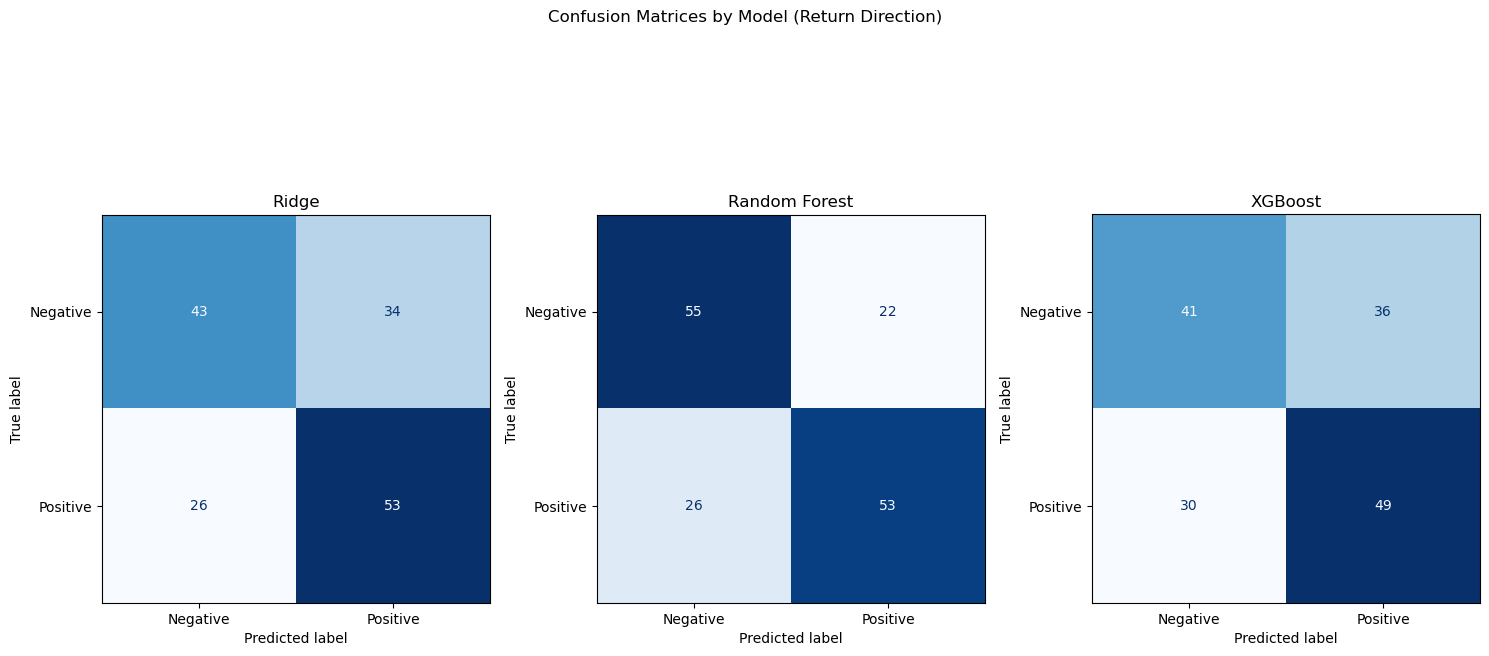

In [276]:
#Confusion matrices
ridge_cm=confusion_matrix(y_test,y_pred_ridge)
rf_cm=confusion_matrix(y_test,y_pred_rf)
xgb_cm=confusion_matrix(y_test,y_pred_xgb)

fig,axes=plt.subplots(1,3,figsize=(15,8))

for ax,cm,title in zip(axes,[ridge_cm, rf_cm, xgb_cm],["Ridge", "Random Forest", "XGBoost"]):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(ax=ax, colorbar=False, cmap="Blues")
    ax.set_title(title)

plt.suptitle("Confusion Matrices by Model (Return Direction)")
plt.tight_layout()
plt.show()

In [275]:
def highlight_rf(row): 
    color="color: green" if row["Model"] == "Random Forest" else ""
    return [color]*len(row)

results = {
    "Model": ["Ridge", "Random Forest", "XGBoost"],
    "Direction Accuracy": [ridge_acc, rf_acc, xgb_acc],
    "Direction Precision": [ridge_prec, rf_prec, xgb_prec],
    "Direction Recall": [ridge_rec, rf_rec, xgb_rec],
    "Direction F1": [ridge_f1, rf_f1, xgb_f1]
}

df = pd.DataFrame(results)
styled_table = (
    df.style
      .set_caption("Model Performance Comparison")
      .set_properties(**{
          "font-size": "12pt",
          "text-align": "center"
      })
      .hide(axis="index")
      .format({
          "Direction Acc.": "{:.4f}",
          "Precision": "{:.2f}",
          "Recall": "{:.2f}",
          "F1": "{:.2f}"
      }).apply(highlight_rf,axis=1)
)

styled_table

Model,Direction Accuracy,Direction Precision,Direction Recall,Direction F1
Ridge,0.615385,0.609195,0.670886,0.638554
Random Forest,0.692308,0.706667,0.670886,0.688312
XGBoost,0.576923,0.576471,0.620253,0.597561


Massive improvement in performance when we tune out the "random noise" in our model (which comes from random movement in the markets), although this does mean that our sample size is much smaller. 

Nonetheless, a performance of ~ 70% accuracy and precision is pretty strong considering the problem at hand. Thus let's focus on that model-Random Forest: 

The most important features in the Random Forest model are: 
1. FinBERT positive sentiment 
2. FinBERT neutral sentiment 
3. Headline length 
4. FinBERT negative sentiment 
5. VADER neutral sentiment. 

It is pretty promising that the most important features are largely these "sentiment scores", in particular the FinBERT ones, which are meant to be geared specifically towards finance. The fact that these features are strong indicators of directionality of the stock and thus our model's predictions, is a sign that our model is tackling our problem in the intended way. Great ! 